# Serie di Seminari su Python 

## Progetto finale

**Raffaele Mura <br/>
Matricola 70/89/00373<br/>
CdS IEEI curriculum informatica**<br/>



#### Progetto scelto:  
Analisi di serie storiche economiche (es. indici di borsa)

Variante 2. Preprocessing dei dati. In questo caso occorre concentrarsi sulle attività di
preprocessing finalizzate a generare I campioni da utilizzare (es. varie medie mobili, up
trend, down trend, ecc.).

#### Introduzione

Il progetto si basa principalmente sulla pre elaborazione dei dati di un dataset, rendendo questi più fruibili da parte di determinati algoritmi di ML il cui fine è predire l'evoluzione futura dei dati stessi.<br/>
Il dataset utilizzato contiene i dati storici, degli ultimi trent'anni, dell'indice di borsa NASDAQ, che è essanzialmente l'indice dei principali titoli tecnologici della borsa americana. <br/>
Il dataset è disponibile sulla piattaforma Yahoo Finanza a questo link: https://it.finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC <br/>
Il progetto è suddiviso in due file.py dal nome `preprocessing.py` e `train&predict`

Prima di passare all'elaborazione dei dati è utile fare una prima esplorazione di questi:


In [138]:
import pandas as pd

df=pd.read_csv("30Y^IXIC.csv")


In [139]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-02-05,422.899994,424.799988,422.399994,424.700012,424.700012,108350000
1,1990-02-06,425.000000,425.200012,422.200012,424.000000,424.000000,119700000
2,1990-02-07,422.000000,426.899994,421.799988,426.799988,426.799988,149300000
3,1990-02-08,428.799988,430.200012,427.100006,427.299988,427.299988,140030000
4,1990-02-09,428.700012,429.100006,427.500000,428.799988,428.799988,125330000


In [140]:
df.shape

(7738, 7)

In [141]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7738.000000,7738.000000,7738.000000,7738.000000,7738.000000,7.738000e+03
mean,2870.677581,2890.186091,2848.310780,2870.522117,2870.522117,1.498975e+09
std,2239.956536,2254.040134,2224.353129,2240.452889,2240.452889,8.803126e+08
min,325.100006,327.899994,323.000000,325.399994,325.399994,4.421000e+07
25%,1347.580017,1362.427460,1335.025024,1348.342529,1348.342529,6.686875e+08
50%,2205.275024,2222.915039,2188.080078,2207.859985,2207.859985,1.706930e+09
75%,3767.789917,3798.609985,3725.467590,3770.192383,3770.192383,2.022478e+09
max,12047.259766,12074.059570,11836.179688,12056.440430,12056.440430,7.279230e+09


Abbiamo un dataset formato da 7738 istanze e 7 features.

# `preprocessing.py`

Dopo aver capito la 'forma' del dataset, eseguiamo la pre elaborazione dei dati.<br/>
Si descriverà passo passo il file di preprocessing.

In [142]:
#importo le librerie
import pandas as pd
from sklearn import preprocessing as sklp

Ora si implementerà una prima funzione il cui fine è interfacciare le varie funzioni del file.py con il dataset <br/>
La variabile fn sta per filename e contine il nome del csv. <br/>
Si susseguono poi una serie di chiamate a funzioni il cui fine verrà riportato subito sotto.<br/>
L'assegnazione `X=X.to_numpy()` ha l'utilità di restiruire una rappresentazione 'Numpy' del DataFrame, con al suo interno solo i valori del DataFrame senza le labels. 

In [143]:
def main():
  
    fn="30Y^IXIC.csv"
  
    df=Csv_to_df(fn)
    df=useful_features(df)
    df=target(df)
    df=clean_df(df)
    df=more_features(df)
  
    X,y=create_Xy(df)
  
    X=X.to_numpy()
    y=y.to_numpy()
  
 
    X_train,y_train,X_test,y_test=split(X,y)
  
    X_train=scaling(X_train)
    X_test=scaling(X_test)
    y_train=scaling(y_train)
    y_test=scaling(y_test)
  
    df_to_csv(df=pd.DataFrame(X_train), fn="NASDAQ_X_train.csv")
    df_to_csv(df=pd.DataFrame(y_train), fn="NASDAQ_y_train.csv")
    df_to_csv(df=pd.DataFrame(X_test), fn="NASDAQ_X_test.csv")
    df_to_csv(df=pd.DataFrame(y_test), fn="NASDAQ_y_test.csv")
  

La funzione `Csv_to_df`, che prende in ingresso il nome del file, crea df che sarà la variabile che referenzia il nostro dataset.

In [144]:
def Csv_to_df(fn):
    
    df=pd.read_csv(fn)
    return df

La funzione `useful_features` ha il fine di aggiungere delle nuove features al dataset.<br/>
Il dataset in questione ora contiene solo dei valori in termini di 'prezzo', ma i prezzi non sono la metrica che cercheremo di prevedere perchè sono misurati in termini assoluti e quindi più difficili da confrontare nel tempo.<br/>
Cercheremo di predire i rendimenti giornalieri. Così creremo una colonna 'returns' che poi assegneremo al target, in modo tale da cercare di predire i rendimenti del giorno successivo.<br/> In modo simile tratteremo le colonne di Open, High e Low.

In [145]:
def useful_features(df):
    
    
    df["Return"]=df.Close/df.Close.shift(1)
    df["Close_open"]=df.Close/df.Open
    df["Close_high"]=df.Close/df.High
    df["Close_low"]=df.Close/df.Low
    df=df.iloc[1:]
    return df


def target(df):
  
    df["y"]=df.Return.shift(-1)
  
    return df


La funzione `clean_df` delega la funzione `missing` che trova i punti del dataframe in cui ci sono elementi mancanti e li 'riempe' con il metodo "ffill" ovvero con il valore dell'elemento che precede quello mancante.<br/>
`clean_df` ora ha il solo fine di chimare `missing`, ma le operazioni di 'pulizia' del dataframe possono essere numerose, e potrebbero essere implementate in un futuro prossimo.

In [146]:
def clean_df(df):
  
    df=missing(df)
  
    return df

def missing(df):
  
    c=df.isnull().sum()
  
    if sum(c)==0:
        return df
    else:
        df=df.fillna(method="ffill", axis=0).fillna("0")
    
    return df

Tramite `more_features` aggiungeremo delle colonne al nostro dataset il cui contenuto vede la rielaborazione dei prezzi, dei rendimenti e del volume, in modo tale da creare dei dati più utili agli algoritmi di ML. <br/>
Il sito https://stockcharts.com è stato preso come riferimento per la comprensione e il calcolo delle nuove features.


In [147]:
def more_features(df):
  
    df=trend(df)
    df=momentum(df)
    df=volatility(df)
    df=volume(df)
  
    return df

## Trend Features

### Moverage averages 

Le medie mobili uniformano i dati sui prezzi per formare un indicatore che segue la tendenza. Non prevedono la direzione dei prezzi, ma piuttosto definiscono la direzione corrente, sebbene siano in ritardo a causa del fatto che si basano sui prezzi passati. Nonostante ciò, le medie mobili aiutano ad attenuare l'azione dei prezzi e a filtrare il rumore. I due tipi più popolari di medie mobili sono la media mobile semplice (SMA) e la media mobile esponenziale (EMA).

Una media mobile semplice si forma calcolando il prezzo medio di un titolo su un numero specifico di periodi. La maggior parte delle medie mobili si basa sui prezzi di chiusura; ad esempio, una media mobile semplice di 5 giorni è la somma di cinque giorni dei prezzi di chiusura divisa per cinque. Come suggerisce il nome, una media mobile è una media che si muove. I vecchi dati vengono eliminati non appena diventano disponibili nuovi dati, facendo sì che la media si sposti lungo la scala temporale.

### Exponential Moving average

Le medie mobili esponenziali (EMA) riducono il ritardo applicando più peso ai prezzi recenti. La ponderazione applicata al prezzo più recente dipende dal numero di periodi nella media mobile. Gli EMA differiscono dalle medie mobili semplici in quanto il calcolo dell'EMA di un dato giorno dipende dai calcoli dell'EMA per tutti i giorni precedenti a quel giorno. Sono necessari molti più di 10 giorni di dati per calcolare un'EMA a 10 giorni ragionevolmente accurata.

Ci sono tre passaggi per calcolare una media mobile esponenziale (EMA). Innanzitutto, si calcola la media mobile semplice per il valore EMA iniziale. Una media mobile esponenziale (EMA) deve iniziare da qualche parte, quindi una media mobile semplice viene utilizzata come EMA del periodo precedente nel primo calcolo. In secondo luogo, si calcola il moltiplicatore di ponderazione. Terzo, si calcola la media mobile esponenziale per ogni giorno tra il valore EMA iniziale e oggi, utilizzando il prezzo, il moltiplicatore e il valore EMA del periodo precedente. 

### MACD
L'oscillatore Moving Average Convergence / Divergence è uno degli indicatori di momentum più semplici ed efficaci disponibili. Il MACD trasforma due indicatori che seguono il trend, le medie mobili, in un oscillatore del momentum sottraendo la media mobile più lunga da quella più breve. Di conseguenza, il MACD offre il meglio di entrambi i mondi: trend following e momentum. Il MACD oscilla sopra e sotto la linea dello zero quando le medie mobili convergono, si incrociano e divergono. 

La linea MACD è la media mobile esponenziale (EMA) a 12 giorni meno l'EMA a 26 giorni. Per queste medie mobili vengono usati i prezzi di chiusura. Viene tracciata un'EMA a 9 giorni dalla linea MACD con l'indicatore che funge da linea di segnale e identifica le svolte. L'istogramma MACD rappresenta la differenza tra MACD e la sua EMA a 9 giorni, la linea di segnale. L'istogramma è positivo quando la linea MACD è sopra la sua linea di segnale e negativo quando la linea MACD è sotto la sua linea di segnale.

I valori di 12, 26 e 9 sono le impostazioni tipiche utilizzate con il MACD, sebbene altri valori possano essere sostituiti a seconda del tuo stile di trading e dei tuoi obiettivi.

N.B. `df.Close.rolling(...).mean()` restituisce la media dei valori interni alla moving window, di valore 50,200..<br/>
`df.Close.ewm(com=(...)).mean()` fornisce una media ponderata esponenziale (EMA), specificando il decadimento in termini di centro di massa: å=1/(1+com), per com>=0 


In [148]:
def trend(df):
  
    df=macd(df)
    df=sma(df)
  
    return df

def sma(df):
  
    df["sma50d"]=df.Close.rolling(50).mean()
    df["sma200d"]=df.Close.rolling(200).mean()
    df["sma50_200"]=df.sma50d-df.sma200d
  
    return df

def macd(df):
  
    ema12d=df.Close.ewm(com=(12-1)/2).mean()
    ema26d=df.Close.ewm(com=(26-1)/2).mean()
  
    df["macd_line"]=ema12d-ema26d
    df["macd9d"]=df.macd_line.ewm(com=(9-1)/2).mean()
    df["macd_diff"]=df.macd_line - df.macd9d
  
    return df


## Momentum Features 

### Stochastic Oscillator

Lo Stochastic Oscillator è un indicatore di momentum che mostra la relazione tra prezzo di chiusura più recente e il range dei prezzi di un determinato periodo. Lo Stochastic Oscillator segue la velocità o lo slancio del prezzo. Di regola, lo slancio cambia direzione prima del prezzo. Pertanto, le divergenze rialziste e ribassiste nell'oscillatore stocastico possono essere utilizzate per prefigurare inversioni. 

Calcolo
% K = (Chiusura corrente - Minimo più basso) / (Massimo più alto - Minimo più basso) * 100
% D = SMA a 3 giorni di% K

L'impostazione predefinita per l'oscillatore stocastico è di 14 periodi, che possono essere giorni, settimane, mesi o un intervallo di tempo intraday. 


### Commodity channel Index

Il Commodity Channel Index (CCI) è un indicatore versatile che può essere utilizzato per identificare una nuova tendenza o l'avvertire di condizioni estreme. In generale, il CCI misura il livello del prezzo corrente rispetto a un livello di prezzo medio in un dato periodo di tempo. Il CCI è relativamente alto quando i prezzi sono molto al di sopra della loro media, ma è relativamente basso quando i prezzi sono molto al di sotto della loro media.

Il calcolo è riportato sotto nella funzione, dove `tp` sta per prezzo tipico e `mdev` per devizione media.



In [149]:
def momentum(df):
  
    df=SO(df)
    df=CCI(df)
 
    return df

def SO(df):
  
    periods=14
  
    df["SO"]=(( df.Close - df.Close.rolling(periods).min()) 
            
              /
            
              (df.Close.rolling(periods).max() - df.Close.rolling(periods).min()))*100
  
  
    return df

def CCI(df):
  
    tp=(df.High+df.Low+df.Close)/3
  
    mdev= abs(tp-tp.rolling(20).mean())/20
  
    df["CCI"]=(tp-tp.rolling(20).mean()) / (0.015*mdev)
  
    return df

## Volatily features

### Bollinger bands

Le Bollinger Bands sono bande di volatilità posizionate sopra e sotto una media mobile. La volatilità si basa sulla deviazione standard, che cambia all'aumentare e diminuire della volatilità stessa. Le bande si allargano automaticamente quando la volatilità aumenta e si contraggono quando la volatilità diminuisce.
  
### Average true range

L'Average True Range (ATR) è un indicatore che misura la volatilità.
In genere, l'Average True Range (ATR) si basa su 14 periodi e può essere calcolato su base infragiornaliera, giornaliera, settimanale o mensile. In questo caso, l'ATR sarà basato sui dati giornalieri. Poiché deve esserci un inizio, il primo valore TR è semplicemente l'Alto meno il Minimo, e il primo ATR di 14 giorni è la media dei valori TR giornalieri degli ultimi 14 giorni. 

In [150]:
def volatility(df):
  
    df["5d_vol"]=df.Return.rolling(5).std()
    df["21d_vol"]=df.Return.rolling(21).std()
    df["60d_vol"]=df.Return.rolling(60).std()
  
    df=BB(df)
    df=ATR(df)
  
    return df

def BB(df):
  
    df["BB"]=((df.Close-df.Close.rolling(21).mean())
            
              /
            
              2*df.Close.rolling(21).std())
  
    return df

def ATR(df):
  
    h_l=df.High-df.Low
    h_prevclose=df.High-df.Close.shift(-1)
    l_prevclose=df.Low-df.Close.shift(-1)
    tr=h_l.to_frame("hig_low")
    tr["high_prevclose"]=h_prevclose
    tr["low_prevclose"]=l_prevclose
    tr["tr"]=tr.max(axis=1)
    df["ATR"]=tr["tr"].rolling(14).mean()
  
    return df
  

## Volume features

### On Balance Volume

On Balance Volume (OBV) misura la pressione di acquisto e vendita come indicatore cumulativo, aggiungendo volume nei giorni in aumento e sottraendolo nei giorni in calo. 

La riga On Balance Volume (OBV) è semplicemente un totale progressivo di volume positivo e negativo. Il volume di un periodo è positivo quando la chiusura è superiore alla chiusura precedente ed è negativo quando la chiusura è inferiore alla chiusura precedente.

Se il prezzo di chiusura è superiore al prezzo di chiusura precedente, allora:
OBV corrente = OBV precedente + volume corrente

Se il prezzo di chiusura è inferiore al prezzo di chiusura precedente, allora:
OBV corrente = OBV precedente - Volume corrente

Se i prezzi di chiusura sono uguali al prezzo di chiusura precedente, allora:
OBV corrente = OBV precedente (nessuna modifica)


### Chaikin Oscillator

Il Chaikin Oscillator misura il momentum della linea di accumulazione/distribuzione utilizzando il MACD. 
Il Chaikin Oscillator è la differenza tra gli EMA a 3 e 10 giorni della linea di accumulazione/distribuzione. Come altri indicatori di momentum, questo indicatore è progettato per anticipare i cambiamenti direzionali nella linea di accumulazione/distribuzione. Un cambiamento di momentum è il primo passo verso un cambiamento di tendenza. 

Il calcolo della linea di accumulazione/distribuzione (ADL) è il primo passo per ottenere il Chaikin Oscillator. Innanzitutto, si calcola il moltiplicatore del flusso di denaro. Secondo, si moltiplica questo valore per il volume per trovare il volume del flusso di denaro. Terzo, si crea un totale parziale del volume del flusso di denaro per formare la linea. Quarto, si prende la differenza tra due medie mobili per calcolare l'oscillatore.


In [151]:
def volume(df):
    
    df["v_rolling"]=df.Volume/df.Volume.shift(21)
    df=OBV(df)
    df=CHKO(df)
  
    return df

def OBV(df):
  
    df["odds"]=df.Close.shift(1)-df.Close
    df["OBV"]=df["Volume"]
    df.OBV=df.apply(lambda row: row.Volume*-1 if row.odds<0 else row.Volume, axis=1)
    df.OBV=df.OBV.cumsum()
  
    return df

def CHKO(df):
  
    flow_mult=((df.Close-df.Low)/ (df.High-df.Low))/(df.High-df.Low)
    flow_vol=df.Volume*flow_mult
    adl=flow_vol.cumsum()
    df["CHKO"]=adl.ewm(com=(3-1)/2).mean()-adl.ewm(com=(10-1)/2).mean()
  
    return df


Nella funzione `create_Xy` divido la table delle features dal vettore target.
Prendo i dati dal duecentesimo in poi date le pre elaborazioni fatte che necessitano 'dello scorrere del tempo' per essere a regime. 

In [152]:
def create_Xy(df):
  
    X=df.loc[200:len(df)-1, ["Close_open","Close_high","Close_low",
                             "sma50_200","macd_diff","SO","CCI","5d_vol","21d_vol","60d_vol"
                             ,"BB","ATR","OBV","CHKO"]]
    y=df.loc[200:len(df)-1, ["y"]]

    return X,y


In `split` Divido i dati in possesso in una parte utile all'addestramento dell'algoritmo e in un altrà che verificherà le performance di predizione dell'algoritmo stesso.<br/> Ovvero nella parte di training userò X_train e y_train per addestrare l'algoritmo, che data la table X_train ne verifica il conseguente target y_train. Nella parte di test l'algoritmo dopo aver 'capito' come i dati evolgono dalla table X al conseguente target y, cerca di predire l'y_test analizzando la table dell'X_test.<br/>
N.B. Il metodo di splitting utilizzato evita la randomizzazione dei campioni.

In [153]:
def split(X,y):
  
    tt_split=5803
    X_train=X[:tt_split]
    y_train=X[:tt_split]
    X_test=X[tt_split:]
    y_test=X[tt_split:]
  
    return X_train,y_train,X_test,y_test


Con `scaling` avviene il ridimensionamento delle features, con media 0 e varianza unitaria, per ridurre il tempo di apprendimento.

In [154]:
def scaling(df):
  
    model=sklp.StandardScaler().fit(df)
    X=model.transform(df)
    return X 


Salvo i dataset come file csv

In [155]:
def df_to_csv(df,fn):
    df.to_csv(fn, index=False)
  

In [156]:
#richiamo il main
main()

# `train&predict.py`

Si utilizzano i dati elaborati e li si applica agli algoritmi scelti.<br/>
Si utilizzeranno in primis algoritmi veloci e di facile interpretazione (Linear Regression) per poi aumentare la complessità (Decision Tree e Neural Networks)

In [157]:
#importo le librerie
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn import tree
from sklearn.neural_network import MLPRegressor


## Metriche performance: 
Dato l'utilizzo di algoritmi di regressione, per calcolare l'errore utilizzerò l'errore medio assoluto (MAE), l'errore quadratico medio (MSE) e e il coefficiente di determinazione R^2.<br/>
Il MAE sarà la differenza tra il valore misurato e il valore vero, quindi come riportato più avanti, la differenza tra il target vero e il target predetto.<br/>
L'MSE indica la discordanza quadratica media fra i valori dei dati osservati ed i valori dei dati stimati.<br/>
L'R^2 rappresenta un indicatore che, partendo dalla retta di regressione, sintetizza in un unico valore di quanto la grandezza analizzata si discosta mediamente da tale retta. L’R-squared può assumere valori compresi fra 0 e 1.<br/> Se è pari a 1 allora esiste una perfetta relazione lineare fra il fenomeno analizzato e la sua retta di regressione.<br/>
Se pari a 0 non esiste alcuna relazione lineare fra le due variabili mentre i valori compresi fra 0 e 1 forniscono una indicazione sulla efficacia della retta di regressione di sintetizzare l’oggetto dell’analisi.

In [158]:
def main2():
  
    X_train=Csv_to_df("NASDAQ_X_train.csv")
    X_test=Csv_to_df("NASDAQ_X_test.csv")
    y_train=Csv_to_df("NASDAQ_y_train.csv")
    y_test=Csv_to_df("NASDAQ_y_test.csv")
  
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
  
    Linear_Regression(X_train,y_train,X_test,y_test)
    Decision_Tree(X_train,y_train,X_test,y_test)
    Neural_Net(X_train,y_train,X_test,y_test)

## Linear Regression
L'algoritmo di Linear Regression si adatta ad un modello lineare con coefficienti w=(w1,...,wp) per minimizzare la somma residua di quadrati tra le risposte osservate nel dataset e le risposte previste dall'approssimazione lineare.<br/>
In particolare la funzione subito sotto prende in ingresso i dataset e target di addestramento e test. <br/>
Succesivamente scelto il modello viene addestrato tramite i dati di train, verrà poi predetto il target dai dati di train e calcolata la performance. Dopo di chè si predirrà il target con i valori di test e si calcolerà la performance.

In [159]:
def Linear_Regression(X_train,y_train,X_test,y_test):
  
    model=linear_model.LinearRegression()
    model.fit(X_train,y_train)
  
    y_pred=model.predict(X_train)
    mae_train,mse_train,r2_train=metrics(y_train,y_pred)
  
    y_pred=model.predict(X_test)
    mae_test,mse_test,r2_test=metrics(y_test,y_pred)
  
    results=pd.DataFrame(columns=["MAE Train","MSE Train", "R2 Train","MAE Test","MSE Test", "R2 Test"])
    results.loc[len(results)]=[mae_train,mse_train,r2_train,mae_test,mse_test,r2_test]
    plotting(results,"Linear Regression")
  
    print(f'Linear Regression: Mae train:  {mae_train} - Mse train:   {mse_train} - R2 train:   {r2_train}')
    print(f'Linear Regression: Mae test:  {mae_test} - Mse test:   {mse_test} - R2 test:   {r2_test}')

## Decision Tree
Gli alberi decisionali (DT) sono un metodo di apprendimento supervisionato non parametrico utilizzato per la classificazione e la regressione. L'obiettivo è creare un modello che preveda il valore di una variabile target apprendendo semplici regole decisionali dedotte dalle caratteristiche dei dati.

Ad esempio, nell'esempio seguente, gli alberi decisionali imparano dai dati per approssimare una curva sinusoidale con un insieme di regole decisionali if-then-else. Più profondo è l'albero, più complesse sono le regole decisionali e più adatto è il modello.


Alcuni vantaggi degli alberi decisionali sono:

E' semplice da capire e da interpretare.
Richiede poca preparazione dei dati. Altre tecniche richiedono spesso la normalizzazione dei dati, la creazione di variabili fittizie e la rimozione dei valori vuoti. Si noti tuttavia che questo modulo non supporta i valori mancanti.
Il costo dell'utilizzo dell'albero (ovvero la previsione dei dati) è logaritmico rispetto al numero di punti utilizzati per addestrare l'albero.
E' in grado di gestire dati sia numerici che categoriali. 

Gli svantaggi degli alberi decisionali includono:

Gli utenti che apprendono l'albero decisionale possono creare alberi troppo complessi che non generalizzano bene i dati, 'overfittando'. Per evitare questo problema sono necessari meccanismi come la potatura, l'impostazione del numero minimo di campioni richiesto su un nodo o l'impostazione della profondità massima dell'albero.
Gli alberi decisionali possono essere instabili perché piccole variazioni nei dati potrebbero comportare la generazione di un albero completamente diverso.

Nel caso sotto riportato:
 - splitter {"best"}, default = "best"; La strategia utilizzata per scegliere la divisione in ogni nodo. 
 - max_depthint, default=None ; La profondità massima dell'albero. Se è None, i nodi vengono espansi finché tutte    le foglie sono pure o finché tutte le foglie non contengono meno di min_samples_split 
 - min_samples_split, default = 2 ;Il numero minimo di campioni necessari per dividere un nodo interno
 - max_leaf_nodes, default = None ; Fa crescere un albero con max_leaf_nodes in best-first. I nodi migliori sono     definiti come riduzione relativa dell'impurità. Se None, si ha un numero illimitato di nodi.
 
 
Oltre la scelta del modello la funzione viene poi implementata come quella precedente

In [160]:
def Decision_Tree(X_train,y_train,X_test,y_test):
    
    model=tree.DecisionTreeRegressor(splitter="best",max_depth=18, min_samples_split=5, max_leaf_nodes=50,)
    model.fit(X_train,y_train)
  
    y_pred=model.predict(X_train)
    mae_train,mse_train,r2_train=metrics(y_train,y_pred)
  
    y_pred=model.predict(X_test)
    mae_test,mse_test,r2_test=metrics(y_test,y_pred)
  
    results=pd.DataFrame(columns=["MAE Train","MSE Train", "R2 Train","MAE Test","MSE Test", "R2 Test"])
    results.loc[len(results)]=[mae_train,mse_train,r2_train,mae_test,mse_test,r2_test]
    plotting(results,"Decision Tree")
  
    print(f'Decision Tree: Mae train:  {mae_train} - Mse train:   {mse_train} - R2 train:   {r2_train}')
    print(f'Decision Tree: Mae test:  {mae_test} - Mse test:   {mse_test} - R2 test:   {r2_test}')       

## Neural Net
MLP (Percettore multistrato) è un algoritmo di apprendimento supervisionato che apprende una funzione
eseguendo l'addestramento su un set di dati, dove m è il numero di dimensioni per l'input e k il numero di dimensioni per l'output. <br/>
Dato un insieme di features e un target, può apprendere un'approssimazione di funzione non lineare sia per la classificazione che per la regressione. <br/>
Parametri scelti:
- hidden_layer_sizes tuple, length = n_layers - 2, default = (100,)
  L'i esimo elemento rappresenta il numero di neuroni nell'i esimo strato nascosto
-  solver {"lbfgs", "sgd", "adam"}, default = "adam" ; Il risolutore per l'ottimizzazione del peso. "Adam" si       riferisce a un ottimizzatore basato su gradiente stocastico.


In [161]:
def Neural_Net(X_train,y_train,X_test,y_test):
  
    model=MLPRegressor(hidden_layer_sizes=(200,200),solver="adam")
    model.fit(X_train,y_train)
  
    y_pred=model.predict(X_train)
    mae_train,mse_train,r2_train=metrics(y_train,y_pred)
  
    y_pred=model.predict(X_test)
    mae_test,mse_test,r2_test=metrics(y_test,y_pred)
  
    results=pd.DataFrame(columns=["MAE Train","MSE Train", "R2 Train","MAE Test","MSE Test", "R2 Test"])
    results.loc[len(results)]=[mae_train,mse_train,r2_train,mae_test,mse_test,r2_test]
    plotting(results,"Neural Net")
  
    print(f'Neural Net: Mae train:  {mae_train} - Mse train:   {mse_train} - R2 train:   {r2_train}')
    print(f'Neural Net: Mae test: {mae_test} - Mse test:   {mse_test} - R2 test:   {r2_test}')

Al di sotto le funzioni per calcolare le performance e plottare i grafici

In [162]:
def metrics(y,y_pred):
  
    mae=mean_absolute_error(y, y_pred)
    mse=mean_squared_error(y, y_pred)
    r2=r2_score(y, y_pred)
  
    return mae,mse,r2

In [166]:
def plotting(results, name):
  
    fig,axes=plt.subplots(3,1, figsize=(10,15))
 
    plt.style.use(['dark_background'])
    plt.suptitle(name, fontsize=20)
    plt.subplots_adjust(left=0.4, top=0.9, right=0.9, bottom=0.1, hspace=0.9)
    results[["MAE Train","MAE Test"]].plot(kind="bar",ax=axes[0],logy=True,  colormap='bwr')
    axes[0].set_title("MAE")
    results[["MSE Train","MSE Test"]].plot(kind="bar",ax=axes[1], logy=True, colormap='bwr')
    axes[1].set_title("MSE")
    results[["R2 Train","R2 Test"]].plot(kind="bar",ax=axes[2], logy=True, colormap='bwr')
    axes[2].set_title("R2")
    plt.show()

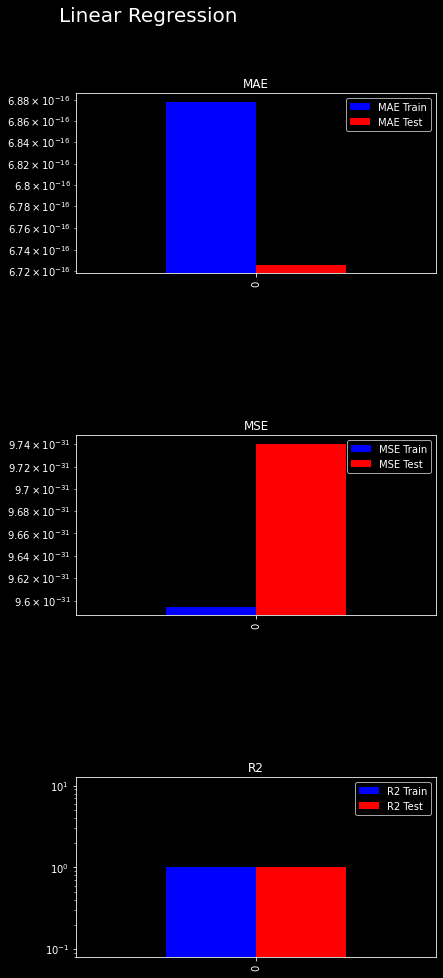

Linear Regression: Mae train:  6.87817962996155e-16 - Mse train:   9.594333559209447e-31 - R2 train:   1.0
Linear Regression: Mae test:  6.725493241039397e-16 - Mse test:   9.740630177100308e-31 - R2 test:   1.0


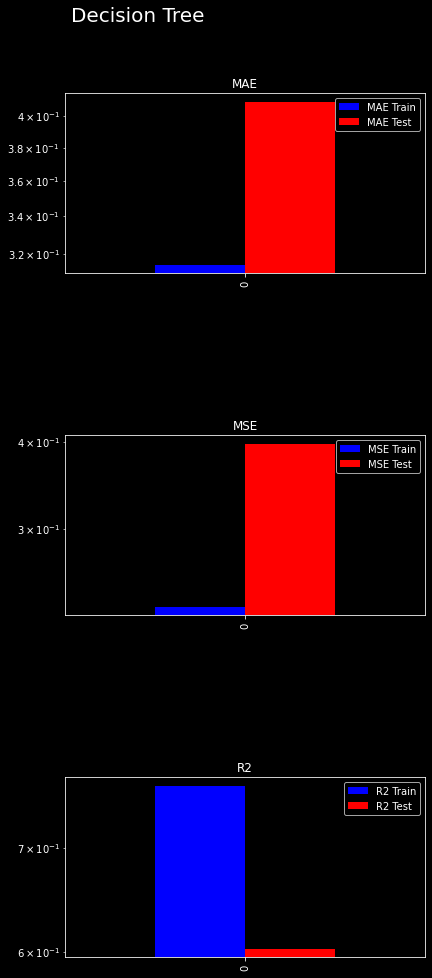

Decision Tree: Mae train:  0.31405189940651884 - Mse train:   0.23213460228232335 - R2 train:   0.7678653977176765
Decision Tree: Mae test:  0.4093168136125187 - Mse test:   0.3976426551346796 - R2 test:   0.6023573448653202


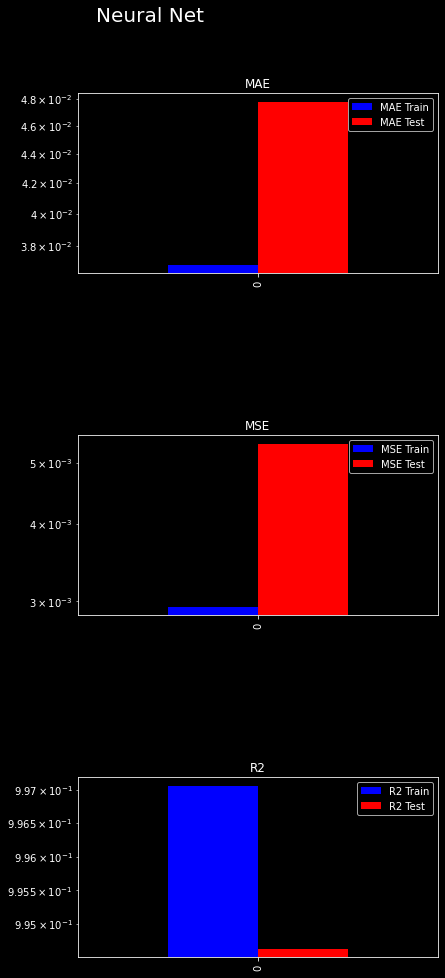

Neural Net: Mae train:  0.036854511285942394 - Mse train:   0.0029361858292775685 - R2 train:   0.9970638141707223
Neural Net: Mae test: 0.04781059727488557 - Mse test:   0.005375422990150749 - R2 test:   0.9946245770098494


In [168]:
main2()